# Text data exploration

Now that we have all 5 datasets combined into a consistent format, let's load up the data and take a quick look at what we have.

## Notebook setup

In [1]:
# Change working directory to parent so we can import as we would
# from the perplexity ratio score root directory
%cd ..

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Internal imports
import configuration as config

/mnt/arkk/llm_detector/perplexity_ratio_score


## 1. Data loading

In [2]:
data_file=f'{config.INTERMEDIATE_DATA_PATH}/all_texts.json'
data_df=pd.read_json(data_file)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3468166 entries, 0 to 3468165
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   text       object
 1   synthetic  int64 
 2   author     object
 3   source     object
dtypes: int64(1), object(3)
memory usage: 105.8+ MB


In [3]:
data_df.head()

,text,synthetic,author,source
0,"and how to handle money, more parents neglect...",1,falcon7,hans
1,When it comes to teaching children about manne...,0,human,hans
2,among a star-studded cast in an upcoming bloc...,1,falcon7,hans
3,Two of Britain’s most distinguished actors are...,0,human,hans
4,"Shane, who used to play for Nottingham Forest ...",1,falcon7,hans


## 2. Data composition

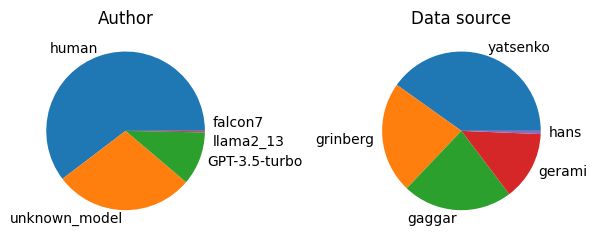

In [4]:
def fix_labels(mylabels, tooclose=0.1, sepfactor=2):
    vecs=np.zeros((len(mylabels), len(mylabels), 2))
    dists=np.zeros((len(mylabels), len(mylabels)))

    for i in range(0, len(mylabels)-1):
        for j in range(i+1, len(mylabels)):
            a=np.array(mylabels[i].get_position())
            b=np.array(mylabels[j].get_position())
            dists[i,j]=np.linalg.norm(a-b)
            vecs[i,j,:]=a-b
            
            if dists[i,j] < tooclose:
                mylabels[i].set_x(a[0] + sepfactor*vecs[i,j,0])
                mylabels[i].set_y(a[1] + sepfactor*vecs[i,j,1])
                mylabels[j].set_x(b[0] - sepfactor*vecs[i,j,0])
                mylabels[j].set_y(b[1] - sepfactor*vecs[i,j,1])

authors=data_df['author'].value_counts()
datasets=data_df['source'].value_counts()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].set_title('Author')
wedges, labels=axs[0].pie(authors, labels=authors.index)
fix_labels(labels, sepfactor=10)
axs[1].set_title('Data source')
axs[1].pie(datasets, labels=datasets.index)
plt.tight_layout()
plt.show()

## 3. Text length

In [5]:
data_df['words']=data_df['text'].apply(lambda x: len(x.split(' ')))
data_df['words'].describe()

count    3.468166e+06
mean     3.528572e+02
std      1.034258e+03
min      1.000000e+00
25%      6.100000e+01
50%      1.960000e+02
75%      4.330000e+02
max      7.775340e+05
Name: words, dtype: float64

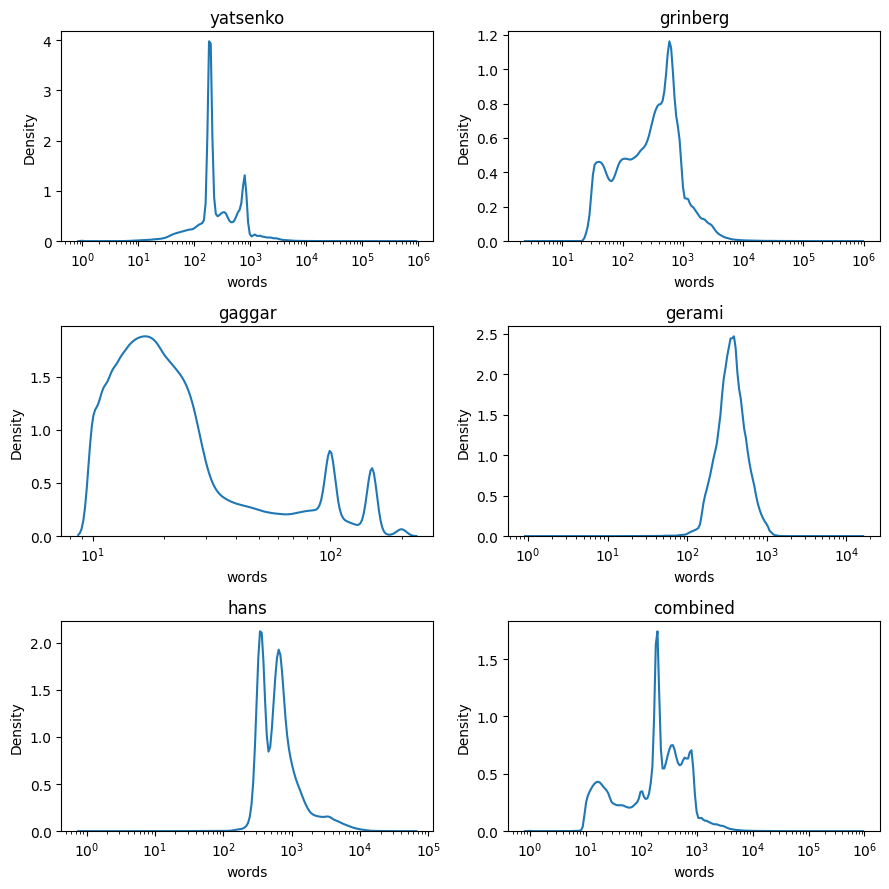

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 9), squeeze=True)
axs=axs.flatten()

for i, dataset in enumerate(datasets.index):
    plot_data_df=data_df[data_df['source'] == dataset]
    sns.kdeplot(data=plot_data_df, x='words', log_scale=10, legend=False, ax=axs[i])
    axs[i].set_title(dataset)

sns.kdeplot(data=data_df, x='words', log_scale=10, legend=False, ax=axs[-1])
axs[-1].set_title('combined')
plt.tight_layout()
plt.show()

OK, most of the records are between about 10 and 10,000 words. Notably, some are much longer - up to a million words! I feel like this must be some kind of junk. Let's manually inspect some of these very long records and see what they are.

### 3.1. Very long records

In [7]:
very_long_records=data_df[data_df['words'] > 10000]
very_long_records['words'].describe()

count      2069.000000
mean      21283.780570
std       30508.873308
min       10005.000000
25%       12051.000000
50%       15168.000000
75%       21491.000000
max      777534.000000
Name: words, dtype: float64

Good - only a tiny fraction of records are longer than 10,000 words. Let's take a look at some of them.

In [8]:
print(very_long_records['text'].iloc[0][:500])

Caracas,
Saturday
February 3,2018 Home | About us | Who's Who | Contacts | Help Search: Venezuela Links Venezuela Overview Venezuelan Embassies & Consulates Around The World Sites/Blogs about Venezuela Venezuelan Newspapers Facts about Venezuela Venezuela Tourism Embassies in Caracas
Colombia Links Colombia Overview Colombian Embassies & Consulates Around the World Government Links Embassies in Bogota Media Sites/Blogs about Colombia Educational Institutions
Wall Street Stocks
Commodity Prices C


Ok, so there is some junk and boilerplate in there - but this pretty obviously came from a scrape of a news website containing the transcript of an interview. I see nothing wrong with it per se. Let's try another one.

In [9]:
print(very_long_records['text'].iloc[1][:500])

"Be careful what you chase. You just might catch it." -- A "Lesterism" from my late, great uncle, Lester Gold.
On the top floor of Building 4 at ESPN's Bristol, Connecticut, campus is an area known as "The Executive Level," where John Skipper and other members of the company's top management have offices.
And as I stood outside The Executive Level in the spring of 2008, my heart was beating superfast. I had been at ESPN for about a year and this was my first time in this area. I had been granted


Same thing.

In [10]:
print(very_long_records['text'].iloc[2][:500])

Sierra Leone Telegraph: 4 July 2018:
The long awaited report of the Governance Transition Team, established by president Julius Maada Bio to look into the manner with which the previous Koroma led APC government ran the country, is out today. It is revealing and makes for sober reading.
It speaks of rampant abuse of office and grotesque levels of corruption by those elected and appointed to serve the people.
The findings are astonishing. It beggars belief as to why anyone elected or employed to 


Yep, I think these are all just scrapes from news sites. The only rational I see for removing them is the fact that they are websites, including the accessory text, not just the article content. We could toss very long records based on that.

Let's take a look at some 10 word and under records.

### 3.2. Very short records

In [11]:
very_short_records=data_df[data_df['words'] <= 10]
very_short_records['words'].describe()

count    42884.000000
mean         9.691074
std          1.349906
min          1.000000
25%         10.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: words, dtype: float64

Many more of these, but they are still a small fraction of the total dataset.

In [12]:
print(very_short_records['text'].iloc[0])

2H7w2lU2gX0Gd1w","_1DOjV4xGjxLb7Rt1J7u2w"],"partnerId":"AolHtb"},"sizes":{"970x90_5000":["970x90_5000","970x90_50k","970x90_55k","970x90_100k"]},"sizesIsStarred":false,"creativeTypes":["html5","inpage"],"targets":[{"network":"AolHtb","size":970,"position":"970x90_50k","type":"inline_image"}],"creative":{"img_url":"","img_url_https":"","url":"","domain":"","hostname":"server8.cnn.net","path":"","media_type":"image","width":970,"height":250,"size":970,"type":"jpg","format":"jpeg","mime_type":"image/jpeg","storage_format":"pjpg"},"tracking":{"pixel_id":"9","pixel_id2":"10","pixel_id3":"11","pixel_id4":"12","pixel_id5":"13","pixel_id6":"14","pixel_id7":"15","pixel_id8":"16","pixel_id9":"17","pixel_id10":"18","pixel_id11":"19","pixel_id12":"20","pixel_id13":"21","pixel_id14":"22","pixel_id15":"23","pixel_id16":"24","pixel_id17":"25","pixel_id18":"26","pixel_id19":"27","pixel_id20":"28","pixel_id21":"29","pixel_id22":"30","pixel_id23":"31","pixel_id24":"32","pixel_id25":"33","pixel_id26":"34

OK - garbage. Try a few more:

In [13]:
for i in range(1,10):
    print(f"\n{very_short_records['text'].iloc[i]}")


aol_sports":[],"mpusd":[{"template":"/new/publishers/example/sites/string","width":320,"height":50},{"template":"/new/publishers/example/sites/string","width":300,"height":250}]},"width":970,"height":250,"format":"320x5000px","publisherID":"1599022","name":"Sample Media Company","caption":null,"title":null,"type":null,"advertiserName":null,"url":"","size":[970,250],"partnerId":"AolHtb"},{"targeting":{"ix_aol_om":["970x90_5000"],"ix_aol_sports":[],"mpusd":[{"template":"/new/publishers/example/sites/string","width":320,"height":50},{"template":"/new/publishers/example/sites/string","width":300,"height":250}]},"width":970,"height":250,"format":"320x5000px","publisherID":"1599022","name":"Sample Media Company","caption":null,"title":null,"type":null,"advertiserName":null,"url":"","size":[970,250],"partnerId":"AolHtb"},{"targeting":{"ix_aol_om":["970x90_5000"],"ix_aol_sports":[],"mpusd":[{"template":"/new/publishers/example/sites/string","width":320,"height":50},{"template":"/new/publisher

Yep - also garbage.

In [14]:
for i in range(40,50):
    print(f"\n{very_short_records['text'].iloc[i]}")


Does microRNA-22 induce endothelial progenitor cell senescence by targeting AKT3?

Who gets a ticket in fucking Wakeeney, Kansas? Me!!! 

@inmyheadstudios happy birthday to your dad! greetings from Mexico 

i hate it when my pic doesnt come up! 

my nagging paid off, I am now a VIW!!! 

Early seventeenth-century Baptists were thought to be influenced by who?

is new to this twittering! UmMmmm..so far so good? 

@rebheartsyou baked, but with yummy spices. healthier that way 

What architect was prominent in Jacksonville prior to the fire?

ahhh finally awake my little tweethearts...subway for lunch yummm 


These? Not so much. Pretty clear that there are things in this size range that we would much rather be rid of, but also things we want to keep. Thinking we should leave it alone for now because a hard length cut is hard to choose rationally. Also, we will end up throwing out the bad with the good. Let's move on and revisit some filtering and cleaning later.

## 4. Shard and save

Next we will be doing some splitting and sampling - so let's break the data into shards, so we can more easily parallelize things moving forward. The master JSON file is ~7.3 GB let's shoot for each file ~500 MB, gives 15 files, call it 16. That way it's even and a square of 2.

In [15]:
# Get rid of the words column we added
data_df.drop('words', axis=1, inplace=True)

# Give it a shuffle
data_df=data_df.sample(frac=1)

# Split the dataframe into 16 chunks
chunks=np.array_split(data_df, 16)

# Save each chunk as parquet with a clean index
for i, chunk in enumerate(chunks):
    output_file=f'{config.INTERMEDIATE_DATA_PATH}/texts.{i}.parquet'
    chunk.reset_index(inplace=True, drop=True)
    chunk.to_parquet(output_file)